In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, SlopeOne, KNNBasic, accuracy
from surprise.model_selection import KFold
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SQLContext

In [2]:
# 加载数据
df1 = pd.read_csv('./netflix-prize-data/combined_data_1.txt', header=None, names=['user_id', 'rating', 'timestamp'])
df2 = pd.read_csv('./netflix-prize-data/combined_data_2.txt', header=None, names=['user_id', 'rating'], usecols=[0, 1])
df3 = pd.read_csv('./netflix-prize-data/combined_data_3.txt', header=None, names=['user_id', 'rating'], usecols=[0, 1])
df4 = pd.read_csv('./netflix-prize-data/combined_data_4.txt', header=None, names=['user_id', 'rating'], usecols=[0, 1])
movies = pd.read_csv('./netflix-prize-data/movie_titles.csv', header=None, names=['movie_id', 'year', 'movie_name'], encoding='ISO-8859-1')
probe = pd.read_csv('./netflix-prize-data/probe.txt', header=None, names=['user_id'])

In [3]:
# 整个数据集数据量太大，运行1小时无果，先尝试使用第一个txt进行训练
df = pd.DataFrame()
df = df.append(df1).append(df2).append(df3).append(df4)

In [13]:
df.reset_index(drop=True, inplace=True)

In [15]:
###数据集预处理###

# 通过提取rating为空值的项组成电影id的dataframe
df_movieid = df[df['rating'].isnull()]
df_movieid.reset_index(inplace=True)

# 尝试过将电影id作为新的列合并到数据集df，但运算量巨大；所以用numpy的array导入电影id
movie_np = []
movie_id = 1
# 将电影id对应的index减去上一个id对应的index再加1就是这部电影的评分数量(i-j+1)
for i,j in zip(df_movieid['index'][1:],df_movieid['index'][:-1]):
    # 每部电影构成一个shape为(1, (i-j-1))的array, shape中(1,的1为电影id
    temp = np.full((1,i-j-1), movie_id)
    # 将所有电影构成的array加到总的array (movie_np)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
# for循环没有将最后一部电影的数据加到movie_np当中，因此需要另外加上
last = np.full((1, len(df)-df_movieid.iloc[-1]['index']-1), movie_id)
movie_np = np.append(movie_np, last)

# 在数据集中去掉电影id的行
df_movieid.set_index(keys='index', inplace=True)
df.drop(df_movieid.index, inplace=True)
# 将电影id作为新的一列加到数据集中
df['movie_id'] = movie_np.astype('int')
df['user_id'] = df['user_id'].astype('int')

KeyboardInterrupt: 

In [ ]:
###数据集预处理###

# 通过提取rating为空值的项组成电影id的dataframe
df_movieid = df[df['rating'].isnull()]
df_movieid.reset_index(inplace=True)

# 尝试过将电影id作为新的列合并到数据集df，但运算量巨大；所以用numpy的array导入电影id
movie_np = []
movie_id = 1
# 将电影id对应的index减去上一个id对应的index再加1就是这部电影的评分数量(i-j+1)
for i in range(1, len(df_movieid)):
    temp = np.full((1,df_movieid['index'][i]-df_movieid['index'][i-1]-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
# for循环没有将最后一部电影的数据加到movie_np当中，因此需要另外加上
last = np.full((1, len(df)-df_movieid.iloc[-1]['index']-1), movie_id)
movie_np = np.append(movie_np, last)

# 在数据集中去掉电影id的行
df_movieid.set_index(keys='index', inplace=True)
df.drop(df_movieid.index, inplace=True)
# 将电影id作为新的一列加到数据集中
df['movie_id'] = movie_np.astype('int')
df['user_id'] = df['user_id'].astype('int')

In [ ]:
df.to_csv('')

In [329]:
# 处理probe数据集的数据
probe_c = probe.copy()
# 将movie_id从user_id列中提取出来作为新的一列并将数据中的':'去掉
movie_col = probe[probe['user_id'].str.contains(':')].copy()
movie_col['user_id'] = movie_col['user_id'].str.split(':').copy()
for i in movie_col.index:
    movie_col['user_id'][i] = movie_col['user_id'][i][0]
probe_c['movie_id'] = movie_col['user_id'].copy()
# 使用'ffill'方法填充na值
probe_c.fillna(method='ffill', inplace=True)
temp = probe[probe['user_id'].str.contains(':')].index.tolist()
probe_c.drop(probe_c.index[temp], inplace=True)
probe = probe_c.copy()
probe['user_id'] = probe['user_id'].astype('int').copy()
probe['movie_id'] = probe['movie_id'].astype('int').copy()
del temp, probe_c, movie_col

In [ ]:
# 从数据集中提取probe的评分
probe_with_rating = pd.DataFrame()
for i in range(1, 17771):
    df_m = df[df['movie_id']==i].copy()
    probe_m = probe[probe['movie_id']==i].copy()
    u_list = probe_m['user_id'].tolist()
    m_rating = df_m[df_m['user_id'].isin(u_list)]
    probe_with_rating = pd.concat([probe_with_rating, m_rating])

# 将结果输出为csv保存
probe_with_rating.to_csv('probe_with_rating.csv')

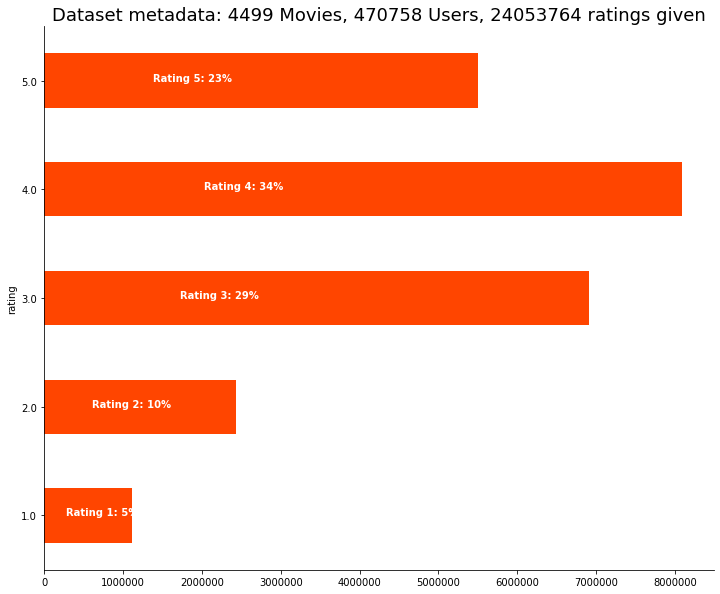

In [171]:
# 评分1-5分的各数量
rating_p = df.groupby('rating')['rating'].agg(['count'])
# 电影数量
movie_num = df['movie_id'].nunique()
# 用户数量
user_num = df['user_id'].nunique()
# 评分的总数量
rating_num = df['rating'].count()
# 画图
ax = rating_p.plot(kind='barh', legend=False, figsize=(12,10), color='orangered')
plt.title('Dataset metadata: %d Movies, %d Users, %d ratings given' % (movie_num, user_num, rating_num), fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(5):
    ax.text(rating_p.iloc[i][0]/4, i, 'Rating %d: %.0f%%' % (i+1, rating_p.iloc[i]*100/rating_p.sum()[0]), color='white', weight='bold')
plt.show()

In [9]:
movies.set_index('movie_id', inplace=True)

In [10]:
# 尝试对整个数据集作训练集运算ALS，但仍由于数据集太大不能得出结果，所以对数据集进行精简：将评分数量很少的用户和评分数量很少的电影过滤掉
df_mov_rat_amount = df.groupby('movie_id')['rating'].count()
df_usr_rat_amount = df.groupby('user_id')['rating'].count()
mov_rat_min_amount = round(df_mov_rat_amount.quantile(0.3), 0)
usr_rat_min_amount = round(df_usr_rat_amount.quantile(0.3), 0)
print(mov_rat_min_amount,'\n', usr_rat_min_amount)

227.0 
 11.0


In [11]:
# 过滤评分数量少于最低值的电影
movie_filter = (df['movie_id'].value_counts() > mov_rat_min_amount)
movie_filter = movie_filter[movie_filter].index.tolist()
# 过滤评分数量少于最低值的用户
user_filter = (df['user_id'].value_counts() > mov_rat_min_amount)
user_filter = user_filter[user_filter].index.tolist()
# 将小于阈值的电影和用户过滤
df_filtered = df[(df['movie_id'].isin(movie_filter)&df['user_id'].isin(user_filter))]
del movie_filter, user_filter, mov_rat_min_amount, usr_rat_min_amount
print(df.shape)
print(df_filtered.shape)

(24053764, 4)
(5062382, 4)


In [12]:
# Pyspark ALS
sc = SparkContext()
sql_sc = SQLContext(sc)
pyspark_df_ratings = sql_sc.createDataFrame(df_filtered).drop('timestamp')

In [13]:
als = ALS(rank=10, maxIter=10, regParam=0.1, userCol='user_id', itemCol='movie_id', ratingCol='rating')
model = als.fit(pyspark_df_ratings)
recommendations = model.recommendForAllUsers(5)

In [16]:
print(recommendations.where(recommendations.user_id==1488844).collect())

[Row(user_id=1488844, recommendations=[Row(movie_id=3456, rating=4.178504467010498), Row(movie_id=2782, rating=4.018551826477051), Row(movie_id=4306, rating=4.008695125579834), Row(movie_id=3425, rating=3.9942030906677246), Row(movie_id=2452, rating=3.9939780235290527)])]


In [174]:
matrix_usr_mov = df.pivot_table(index='user_id', columns='movie_id', values='rating')

In [323]:
probe_with_rating.to_csv('probe_with_rating_1.csv')

,user_id,movie_id
28,2326571,1000
29,977808,1000
30,1010534,1000
31,1861759,1000
32,79755,1000
33,98259,1000
34,1960212,1000
35,97460,1000
36,2623506,1000
37,2409123,1000


In [215]:
probe_rating = probe.groupby(['movie_id', 'user_id'])

In [224]:
probe_rating.sum()

rating
movie_id user_id        
1        14756       0.0
         30878       0.0
         317050      0.0
         470861      0.0
         548064      0.0
...                  ...
17770    605115      0.0
         829192      0.0
         1196966     0.0
         1476398     0.0
         2334295     0.0

[1408395 rows x 1 columns]